# This notebook must be run with the Vizgen_2 conda environment within the Vizgen.sif singularity container

In [6]:
import scanpy as sc
import pandas as pd
import os
import string
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import Mapping
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial
import anndata
from adjustText import adjust_text
import seaborn as sns

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import spearmanr

In [7]:
def calculate_spearman_corr(adata, gene_columns, morpho_columns):
    """
    Calculate Spearman correlation between gene expression and morphological features.
    
    Parameters:
    - adata: AnnData object containing gene expression and morphological features.
    - gene_columns: List of gene names in adata.var_names.
    - morpho_columns: List of morphological feature names in adata.obs.
    
    Returns:
    - A DataFrame with Spearman correlation coefficients between genes and morphological features.
    """
    # Extract gene expression data (assume it's stored in adata.X or adata.var)
    gene_expr_df = pd.DataFrame(adata[:, gene_columns].X, columns=gene_columns, index=adata.obs_names)
    
    # Extract morphological features from adata.obs
    morpho_df = adata.obs[morpho_columns]
    
    # Initialize a DataFrame to store the correlations
    corr_matrix = pd.DataFrame(index=gene_columns, columns=morpho_columns)

    # Calculate Spearman correlation for each gene-morphological feature pair
    for gene in gene_columns:
        for morpho in morpho_columns:
            corr, _ = spearmanr(gene_expr_df[gene], morpho_df[morpho])
            corr_matrix.at[gene, morpho] = corr

    # Convert the correlation matrix to numeric values
    corr_matrix = corr_matrix.astype(float)

    return corr_matrix

def cluster_morphological_features(corr_matrix):
    """
    Cluster the morphological features based on their correlation with genes.
    
    Parameters:
    - corr_matrix: DataFrame containing correlation coefficients between genes and morphological features.
    
    Returns:
    - Clustering of the morphological features and a dendrogram plot.
    """
    # Cluster the morphological features using hierarchical clustering
    linkage_matrix = linkage(corr_matrix.T, method='ward')
    
    # Plot dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram(linkage_matrix, labels=corr_matrix.columns)
    plt.title('Clustering of Morphological Features Based on Gene Correlations')
    plt.xlabel('Morphological Features')
    plt.ylabel('Distance')
    plt.show()

    return linkage_matrix

def rank_genes_by_contribution(corr_matrix, linkage_matrix, n_clusters=5):
    """
    Rank genes by their contribution to clustering the morphological features.
    
    Parameters:
    - corr_matrix: DataFrame containing Spearman correlation coefficients.
    - linkage_matrix: The linkage matrix obtained from hierarchical clustering.
    - n_clusters: The number of clusters for the morphological features.
    
    Returns:
    - A DataFrame ranking the genes by their contribution to clustering the morphological features.
    """
    # Create clusters of morphological features
    morpho_clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    
    # Rank genes by their average correlation with features in the same cluster
    gene_contribution = pd.Series(index=corr_matrix.index, dtype=float)
    for gene in corr_matrix.index:
        mean_corr_per_cluster = []
        for cluster in np.unique(morpho_clusters):
            cluster_features = corr_matrix.columns[morpho_clusters == cluster]
            mean_corr_per_cluster.append(corr_matrix.loc[gene, cluster_features].mean())
        # Average the correlations across clusters
        gene_contribution[gene] = np.mean(mean_corr_per_cluster)
    
    # Sort the genes by their contribution
    ranked_genes = gene_contribution.sort_values(ascending=False)
    
    return ranked_genes

def plot_correlation_heatmap(corr_matrix):
    """
    Plot a heatmap of the Spearman correlation matrix.
    
    Parameters:
    - corr_matrix: DataFrame containing Spearman correlation coefficients.
    
    Returns:
    - Displays a heatmap.
    """
    # Create the heatmap using seaborn
    plt.figure(figsize=(12, 6))
    sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, cbar=True)
    
    # Customize plot labels
    plt.title('Spearman Correlation (Genes - Morphological Features)')
    plt.xlabel('Morphological Features')
    plt.ylabel('Genes')
    
    plt.tight_layout()
    plt.show
    
def top_genes_per_morphology(corr_matrix, top_n=20):
    """
    Get the top N genes and their Spearman correlation values for each morphology feature.
    
    Parameters:
    - corr_matrix: DataFrame containing Spearman correlation values (genes as rows, morphological features as columns).
    - top_n: The number of top genes to return for each morphology feature (default: 20).
    
    Returns:
    - A dictionary where each key is a morphological feature, and the value is a DataFrame with the top genes and their Spearman values.
    """
    top_genes_dict = {}

    # Iterate through each morphology feature
    for morpho in corr_matrix.columns:
        # Sort genes by Spearman correlation value in descending order
        top_genes = corr_matrix[morpho].sort_values(ascending=False).head(top_n)
        
        # Store the top genes and their Spearman values in a DataFrame
        top_genes_dict[morpho] = pd.DataFrame({
            'Gene': top_genes.index,
            'Spearman_Correlation': top_genes.values
        })
    
    return top_genes_dict

def top_5_genes_correlation_matrix(corr_matrix):
    """
    Create a new correlation matrix that includes only the top 5 genes for each morphology feature.
    
    Parameters:
    - corr_matrix: DataFrame containing Spearman correlation values (genes as rows, morphological features as columns).
    
    Returns:
    - A new DataFrame with the top 5 genes for each morphology feature.
    """
    # Initialize an empty set to store the top 5 genes across all morphologies
    top_genes_set = set()
    
    # Find the top 5 genes for each morphology feature and add them to the set
    for morpho in corr_matrix.columns:
        top_genes = corr_matrix[morpho].sort_values(ascending=False).head(5).index
        top_genes_set.update(top_genes)
    
    # Create a new correlation matrix that includes only the top 5 genes for each morphology feature
    new_corr_matrix = corr_matrix.loc[[i for i in top_genes_set]]
    
    return new_corr_matrix

In [8]:
new_ad = sc.read_h5ad('Transciptomic_labels_and_morphology_labels_full.h5ad')

In [9]:
start_index = list(new_ad.obs.columns).index('Cell Area')  # Add 1 to include the column itself
columns_after_specific = new_ad.obs.iloc[:, start_index:].values

morphological_columns = new_ad.obs.columns[start_index:]

features = morphological_columns[:-12].tolist()

features = [i for i in features if i not in ['Radius of Influence','Ramification Index']]

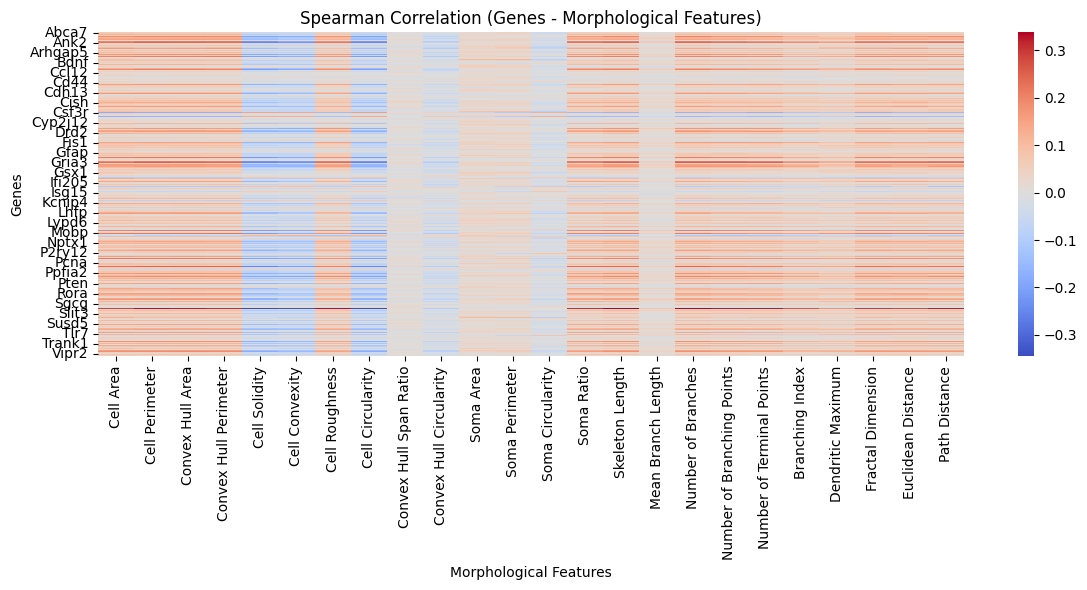

In [10]:
corr_matrix = calculate_spearman_corr(new_ad, new_ad.var_names.tolist(), features)
plot_correlation_heatmap(corr_matrix)

In [11]:
top_genes_dict = top_genes_per_morphology(corr_matrix, top_n=6)

new_corr_matrix = top_5_genes_correlation_matrix(corr_matrix)

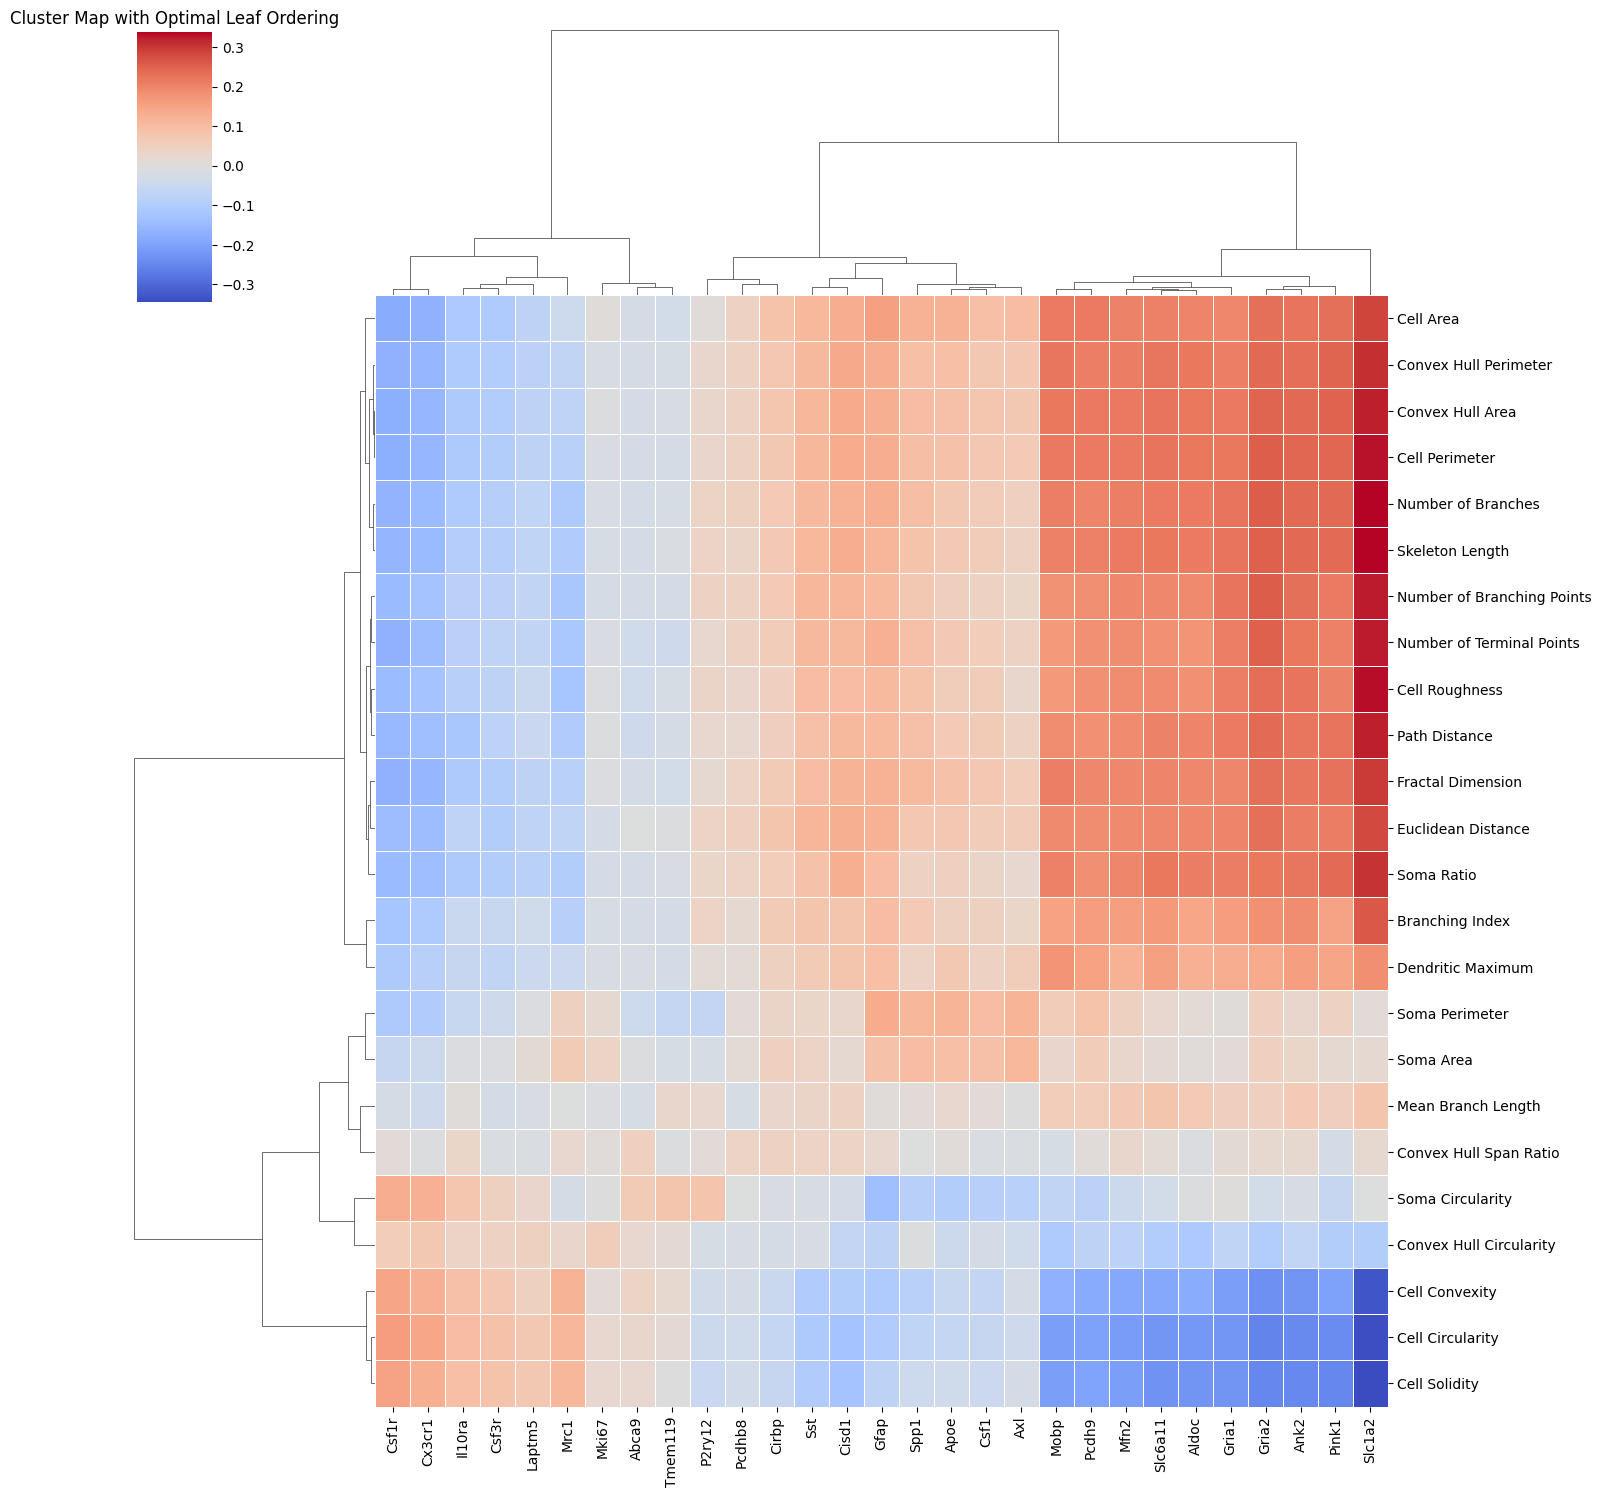

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

def plot_ordered_clustermap(corr_matrix,output_pdf = None):
    """
    Plot a clustermap with rows and columns ordered to achieve a diagonal structure.
    
    Parameters:
    - corr_matrix: DataFrame containing the correlation matrix.
    
    Returns:
    - A seaborn cluster map plot.
    """
    # Perform hierarchical clustering with optimal leaf ordering
    row_linkage = sch.linkage(corr_matrix, method='ward', optimal_ordering=True)
    col_linkage = sch.linkage(corr_matrix.T, method='ward', optimal_ordering=True)
    
    # Plot the cluster map
    sns.clustermap(corr_matrix, row_linkage=row_linkage, col_linkage=col_linkage, cmap="coolwarm", 
                   linewidths=0.5, figsize=(15, 15), method='ward')
    
    plt.title('Cluster Map with Optimal Leaf Ordering')
    if output_pdf:
        plt.savefig('figures/morph_to_gene.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
plot_ordered_clustermap(new_corr_matrix.T,output_pdf=True) 

In [17]:
#ordered = ['Slc1a2', 'Gria2','Pink1', 'Ank2','Gria1','Slc6a11','Aldoc','Gnas','Mfn2','Atp2a2','Mobp','Pcdh9','Gfap','Aqp4','Sdc3','Cisd1','Sst','Spp1','Apoe','Axl','Pcdhb8','Cxcl3','Rbm3','Cemip2','Cirbp','P2ry12','Abca9','Tmem119',
 #          'Stab1','Cd33','Mki67','Ifi207','Mrc1','Il10ra','Csf3r','Cx3cr1','Csf1r']

ordered = [
    "Slc1a2", "Pink1", "Ank2", "Gria2", "Gria1", "Aldoc", "Slc6a11", "Mfn2", 
    "Pcdh9", "Axl", "Csf1", "Apoe", "Spp1", "Gfap", "Cisd1", "Sst", "Cirbp", 
    "Pcdhb8", "P2ry12", "Tmem119", "Abca9",'Mki67', "Mrc1", "Laptm5", "Csf3r", 
    "Il10ra", "Cx3cr1", "Csf1r"
]

#ord_feat = ['Cell Area', 'Convex Hull Perimeter', 'Convex Hull Area','Cell Perimeter','Number of Branches','Skeleton Length','Cell Roughness','Number of Terminal Points',
 #          'Number of Branching Points','Soma Ratio','Path Distance','Fractal Dimension','Euclidean Distance','Tortuosity','Branching Index','Dendritic Maximum','Soma Area',
  #         'Soma Perimeter','Eccentricity','Mean Branch Length','Convex Hull Span Ratio','Lacunarity','Soma Circularity','Soma Circularity','Convex Hull Circularity','Cell Convexity',
   #        'Cell Circularity','Cell Solidity']

ord_feat = ["Cell Area", "Convex Hull Perimeter", "Convex Hull Area", "Cell Perimeter", 
    "Number of Branches", "Skeleton Length", "Number of Branching Points", 
    "Number of Terminal Points", "Cell Roughness", "Path Distance", 
    "Fractal Dimension", "Euclidean Distance", "Soma Ratio", 
    "Branching Index", "Dendritic Maximum", "Soma Perimeter", "Soma Area", 
    "Mean Branch Length", "Convex Hull Span Ratio", "Soma Circularity", 
    "Convex Hull Circularity", "Cell Convexity", "Cell Circularity", 
    "Cell Solidity"]

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_clustered_zscore_heatmap(adata, gene_list, group_col='sub_mic',cmap="coolwarm",output_pdf=None):
    """
    Plot a z-score heatmap for a set of genes, grouped and clustered by sub_mic.
    
    Parameters:
    - adata: AnnData object containing gene expression data.
    - gene_list: List of genes to include in the heatmap.
    - group_col: Column name in obs to group by (default: 'sub_mic').
    
    Returns:
    - A clustered heatmap of z-scores for the selected genes, grouped by sub_mic.
    """
    # Extract gene expression data for the selected genes
    gene_expr_df = pd.DataFrame(adata[:, gene_list].X, columns=gene_list, index=adata.obs_names)
    
    # Add the grouping column (sub_mic) to the gene expression DataFrame
    gene_expr_df[group_col] = adata.obs[group_col].values
    
    # Group by sub_mic and calculate the mean expression for each gene in each sub_mic group
    grouped_expr = gene_expr_df.groupby(group_col).mean()

    # Calculate z-scores for each gene across the sub_mic groups
    zscore_expr = grouped_expr.apply(zscore, axis=0)

    # Perform hierarchical clustering on the rows (sub_mic groups)
    row_linkage = linkage(zscore_expr, method='ward')
    col_linkage = linkage(zscore_expr.T, method='ward')

    # Create a clustered heatmap
    #sns.clustermap(zscore_expr,row_linkage=row_linkage,col_linkage=col_linkage, cmap=cmap, linewidths=0.5, figsize=(10, 6), annot=False)
    
    row_linkage = linkage(zscore_expr, method='ward')
    row_order = leaves_list(row_linkage)  # Get the leaf order based on clustering

    # Reorder the rows based on the hierarchical clustering result
    zscore_expr = zscore_expr.iloc[row_order]
    print(row_order)
    # Create a heatmap without clustering the columns
    fig, ax = plt.subplots(figsize=(20, 10))
    
    sns.heatmap(zscore_expr, cmap=cmap, linewidths=0.5, annot=False,ax=ax)
    # Customize plot labels
    plt.title('Clustered Z-Score Heatmap of Genes Grouped by Sub_mic')
    plt.xlabel('Genes')
    plt.ylabel('Sub_mic Groups')

    plt.tight_layout()
    if output_pdf:
        plt.savefig(output_pdf, format='pdf', bbox_inches='tight')
    plt.show()
    
    sns.heatmap(zscore_expr)
    return zscore_expr
    
def plot_clustered_heatmap_with_features(adata, feature_list, group_col='sub_mic',cmap="coolwarm",output_pdf=None):
    """
    Plot a z-score heatmap for the morphological features (from adata.obs) grouped by sub_mic.
    
    Parameters:
    - adata: AnnData object containing morphological features in obs.
    - feature_list: List of feature columns in adata.obs to include in the heatmap.
    - group_col: Column name in obs to group by (default: 'sub_mic').
    
    Returns:
    - A clustered heatmap of z-scores for the selected morphological features, grouped by sub_mic.
    """
    # Extract the morphological features from adata.obs
    feature_df = adata.obs[feature_list]
    
    # Add the grouping column (sub_mic) to the morphological features DataFrame
    feature_df[group_col] = adata.obs[group_col].values
    
    # Group by sub_mic and calculate the mean value for each feature in each sub_mic group
    grouped_features = feature_df.groupby(group_col).mean()

    # Calculate z-scores for each feature across the sub_mic groups
    zscore_features = grouped_features.apply(zscore, axis=0)

    # Perform hierarchical clustering on the rows (sub_mic groups) and columns (features)
    row_linkage = linkage(zscore_features, method='ward')
    col_linkage = linkage(zscore_features.T, method='ward')

    # Create a clustered heatmap
    #sns.clustermap(zscore_features, row_linkage=row_linkage, col_linkage=col_linkage, 
     #              cmap=cmap, linewidths=0.5, figsize=(10, 8), annot=False)
        
    row_linkage = linkage(zscore_features, method='ward')
    row_order = leaves_list(row_linkage)  # Get the leaf order based on clustering

    # Reorder the rows based on the hierarchical clustering result
    # trans = [1, 0, 2]
    # morph = [4, 3, 2,1,0]
    zscore_features = zscore_features.iloc[row_order]
    print(row_order)
    # Create a heatmap without clustering the columns
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(zscore_features, cmap=cmap, linewidths=0.5, annot=False,ax=ax)

    # Customize plot labels
    plt.title('Clustered Z-Score Heatmap of Morphological Features Grouped by Sub_mic')
    plt.xlabel('Morphological Features')
    plt.ylabel('Sub_mic Groups')

    plt.tight_layout()
    if output_pdf:
        plt.savefig(output_pdf, format='pdf', bbox_inches='tight')
    plt.show()
    
    sns.heatmap(zscore_features)
    return zscore_features

/tmp/ipykernel_1436634/585396952.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_expr = gene_expr_df.groupby(group_col).mean()


[0 1 2]


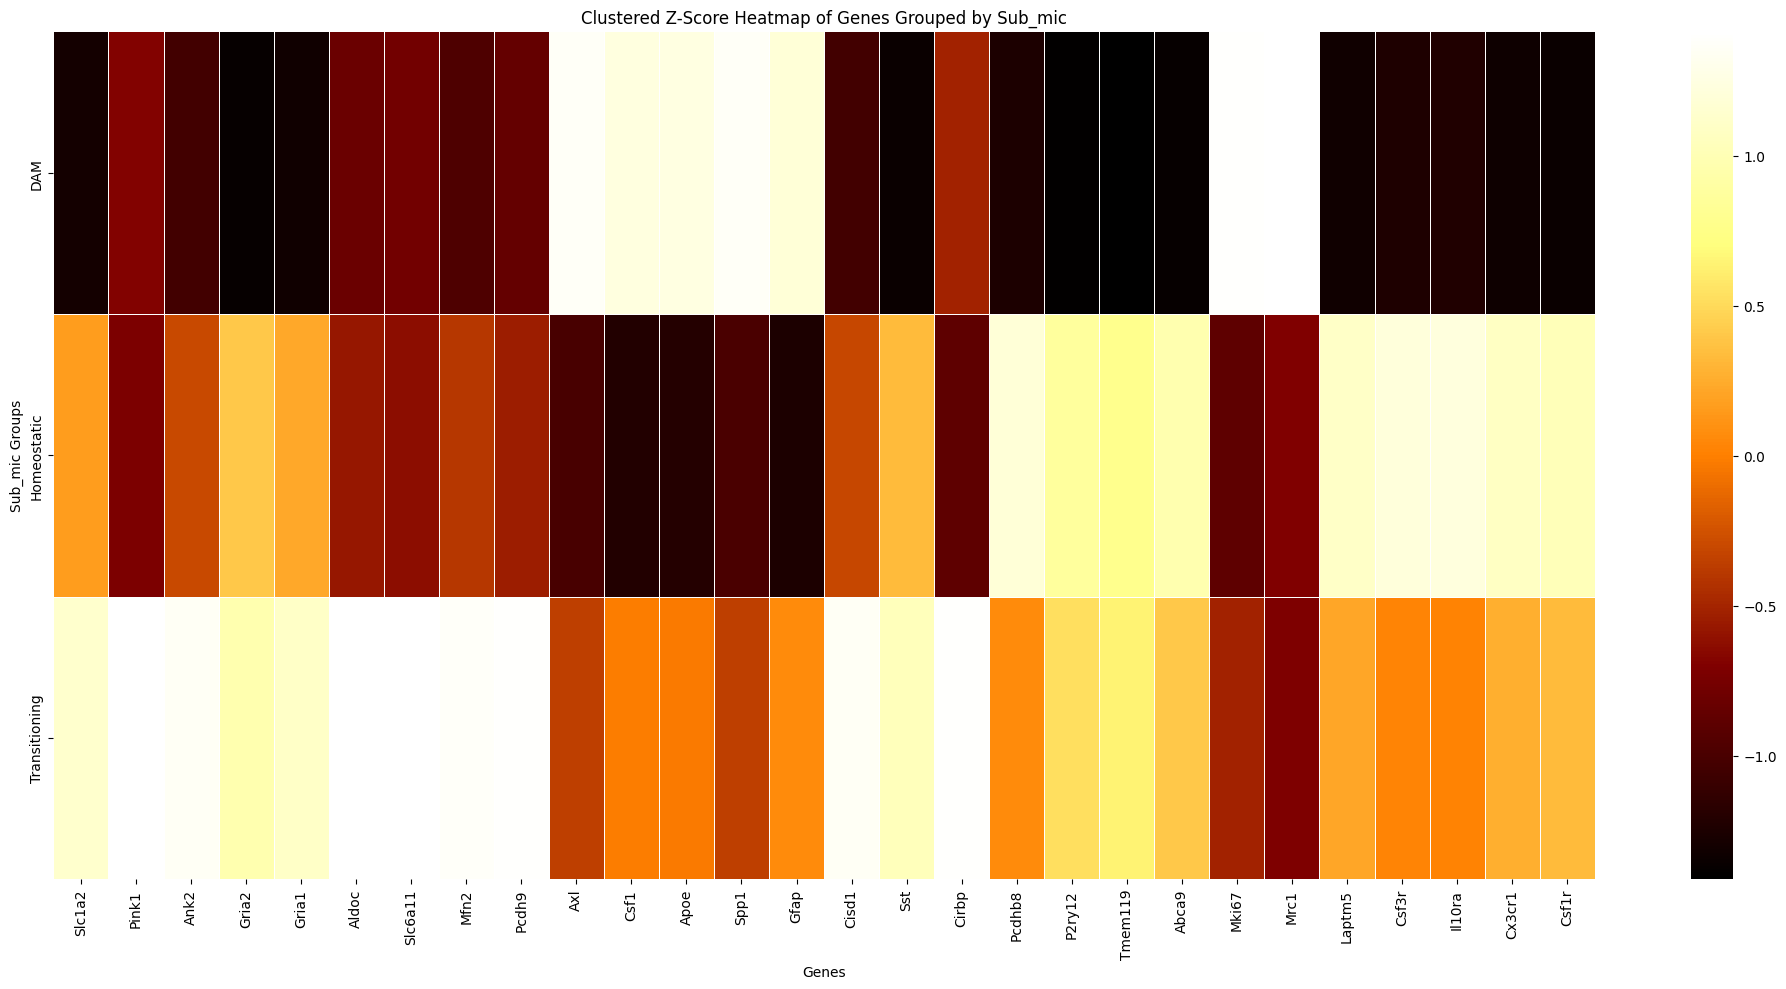

,Slc1a2,Pink1,Ank2,Gria2,Gria1,Aldoc,Slc6a11,Mfn2,Pcdh9,Axl,...,P2ry12,Tmem119,Abca9,Mki67,Mrc1,Laptm5,Csf3r,Il10ra,Cx3cr1,Csf1r
sub_mic,,,,,,,,,,,,,,,,,,,,,
DAM,-1.297331,-0.688558,-1.042378,-1.375591,-1.321258,-0.825596,-0.778813,-0.976021,-0.855719,1.363170,...,-1.399998,-1.411794,-1.376766,1.397216,1.41419,-1.317393,-1.238245,-1.232837,-1.332251,-1.356587
Homeostatic,0.161121,-0.725495,-0.306510,0.403520,0.223927,-0.581583,-0.632888,-0.398295,-0.547235,-1.007661,...,0.873215,0.777510,0.968359,-0.887924,-0.70005,1.104068,1.210783,1.216489,1.077016,1.024346
Transitioning,1.136210,1.414053,1.348888,0.972070,1.097330,1.407179,1.411702,1.374316,1.402954,-0.355508,...,0.526783,0.634284,0.408407,-0.509292,-0.71414,0.213330,0.027462,0.016347,0.255233,0.332243


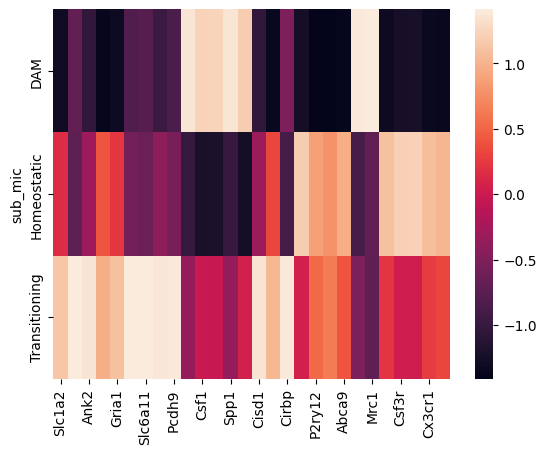

In [19]:
gene_list = new_corr_matrix.index.tolist()  # Use the genes from corr_matrix
plot_clustered_zscore_heatmap(new_ad, ordered,'sub_mic','afmhot',output_pdf='figures/cluster_mic_by_correlating_genes.pdf')

/tmp/ipykernel_1436634/585396952.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_expr = gene_expr_df.groupby(group_col).mean()


[1 3 0 2 4]


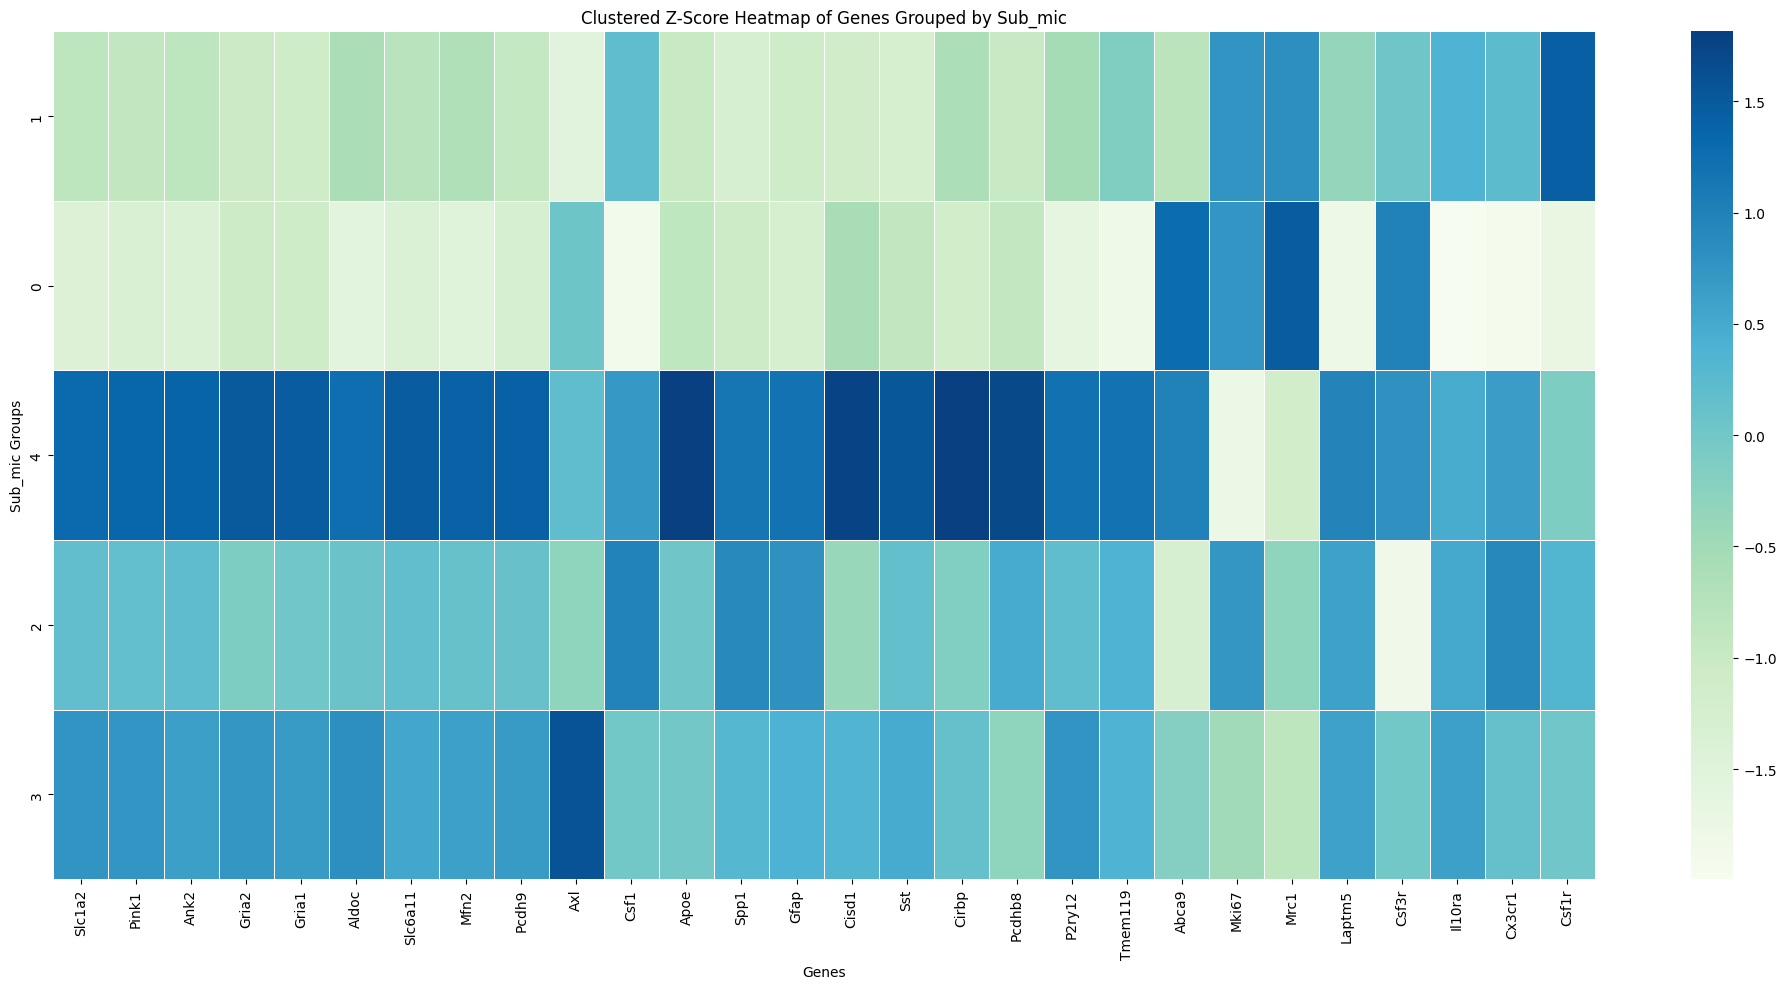

,Slc1a2,Pink1,Ank2,Gria2,Gria1,Aldoc,Slc6a11,Mfn2,Pcdh9,Axl,...,P2ry12,Tmem119,Abca9,Mki67,Mrc1,Laptm5,Csf3r,Il10ra,Cx3cr1,Csf1r
ordered_morph,,,,,,,,,,,,,,,,,,,,,
1,-0.848142,-0.900185,-0.839686,-1.039977,-1.088498,-0.597659,-0.786752,-0.662369,-0.925458,-1.532698,...,-0.534560,-0.136935,-0.813943,0.758525,0.826915,-0.354707,0.042675,0.382374,0.223812,1.436978
0,-1.399494,-1.341946,-1.395164,-1.070503,-1.080766,-1.549019,-1.382566,-1.485211,-1.287652,0.049997,...,-1.627256,-1.811739,1.292279,0.742984,1.478423,-1.800339,0.985434,-1.994025,-1.920834,-1.675359
4,1.305092,1.345110,1.375512,1.487406,1.481125,1.250188,1.472054,1.399832,1.419557,0.196833,...,1.197094,1.186855,0.992341,-1.757641,-1.148919,0.956222,0.799843,0.471416,0.639520,-0.117598
2,0.175796,0.150848,0.220887,-0.116239,0.014965,0.075064,0.176149,0.132709,0.117964,-0.301243,...,0.192613,0.385574,-1.283666,0.740647,-0.311930,0.597385,-1.840433,0.518379,0.910957,0.337794
3,0.766747,0.746172,0.638452,0.739312,0.673172,0.821427,0.521115,0.615040,0.675589,1.587087,...,0.772108,0.376245,-0.187013,-0.484516,-0.844489,0.601442,0.012478,0.621854,0.146547,0.018192


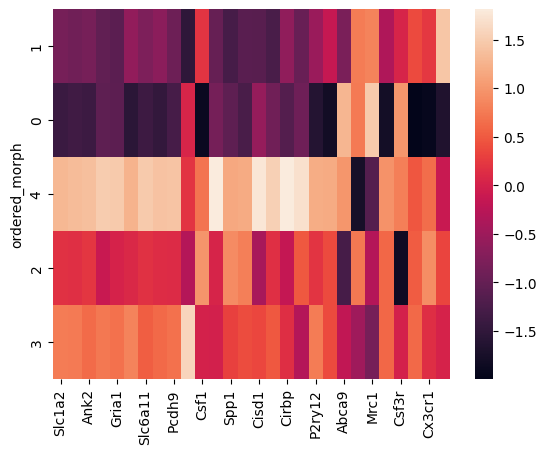

In [20]:
gene_list = new_corr_matrix.index.tolist()  # Use the genes from corr_matrix
plot_clustered_zscore_heatmap(new_ad, ordered,group_col='ordered_morph',cmap='GnBu',output_pdf='figures/cluster_morph_by_correlating_genes.pdf')

/tmp/ipykernel_1436634/585396952.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df[group_col] = adata.obs[group_col].values
/tmp/ipykernel_1436634/585396952.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_features = feature_df.groupby(group_col).mean()


[2 0 1]


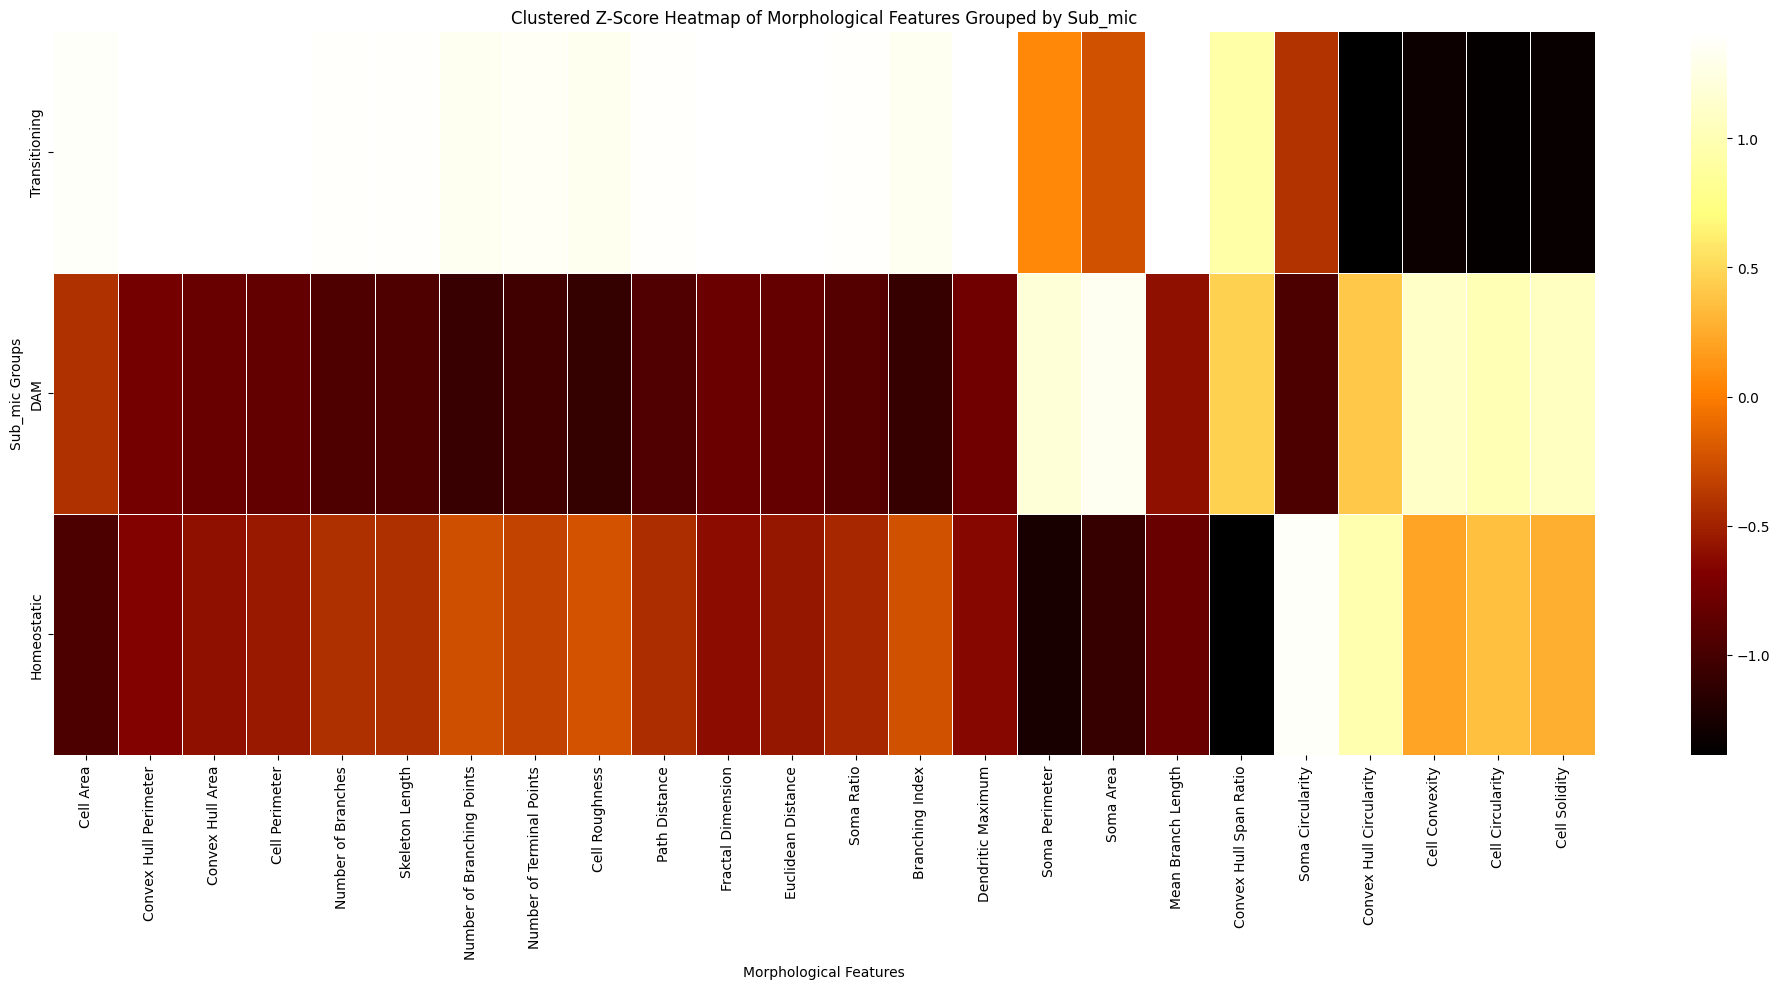

,Cell Area,Convex Hull Perimeter,Convex Hull Area,Cell Perimeter,Number of Branches,Skeleton Length,Number of Branching Points,Number of Terminal Points,Cell Roughness,Path Distance,...,Dendritic Maximum,Soma Perimeter,Soma Area,Mean Branch Length,Convex Hull Span Ratio,Soma Circularity,Convex Hull Circularity,Cell Convexity,Cell Circularity,Cell Solidity
sub_mic,,,,,,,,,,,,,,,,,,,,,
Transitioning,1.378710,1.413449,1.408588,1.403710,1.381628,1.382212,1.333004,1.352235,1.324123,1.383717,...,1.412642,0.065307,-0.240203,1.409022,0.930519,-0.413458,-1.376657,-1.319580,-1.364402,-1.338112
DAM,-0.416650,-0.746997,-0.813427,-0.850845,-0.952211,-0.950176,-1.075555,-1.034719,-1.092205,-0.944833,...,-0.764044,1.190785,1.327051,-0.599665,0.457021,-0.964505,0.407949,1.100281,1.004390,1.065404
Homeostatic,-0.962061,-0.666452,-0.595161,-0.552866,-0.429417,-0.432036,-0.257449,-0.317516,-0.231918,-0.438884,...,-0.648598,-1.256092,-1.086848,-0.809357,-1.387540,1.377963,0.968708,0.219299,0.360012,0.272709


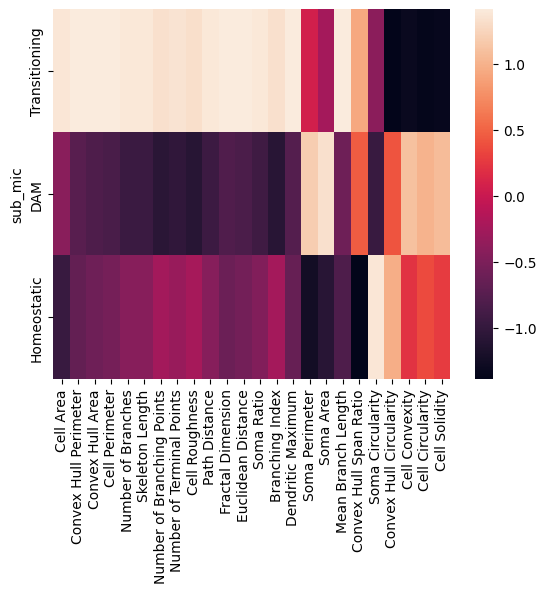

In [21]:
plot_clustered_heatmap_with_features(new_ad, ord_feat, group_col='sub_mic',cmap='afmhot',output_pdf='figures/cluster_mic_by_morph_features.pdf')

/tmp/ipykernel_1436634/585396952.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df[group_col] = adata.obs[group_col].values
/tmp/ipykernel_1436634/585396952.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_features = feature_df.groupby(group_col).mean()


[1 3 0 2 4]


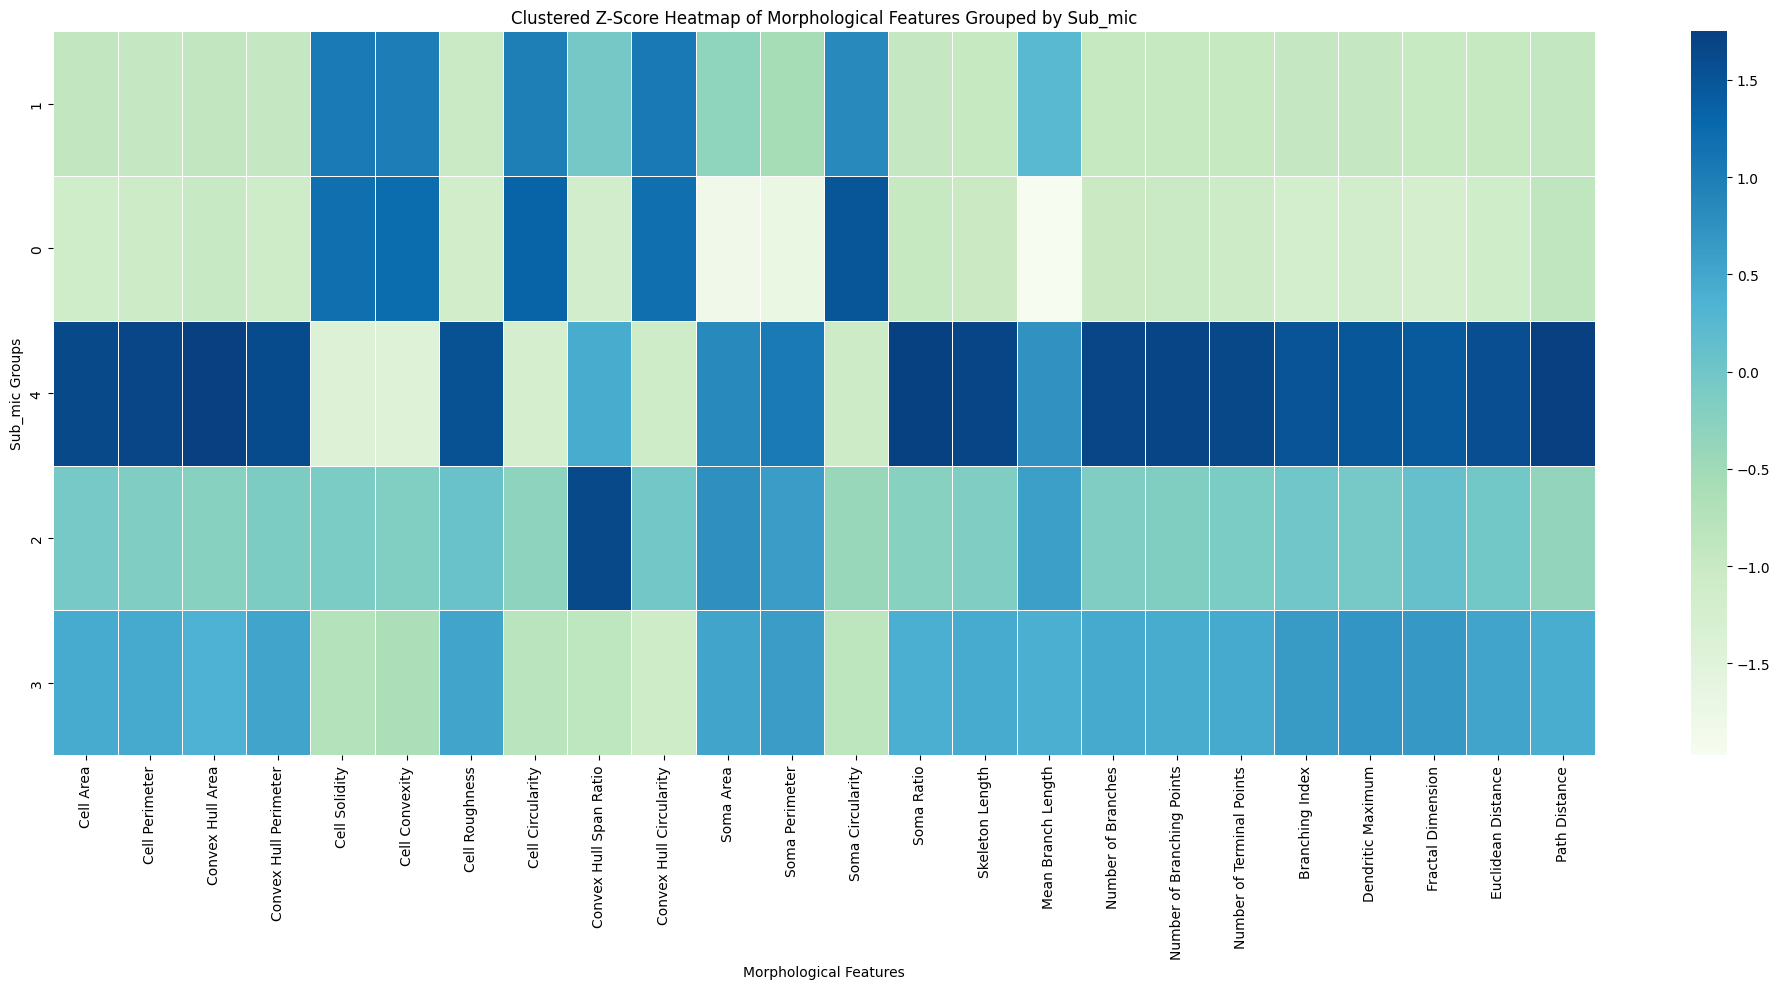

,Cell Area,Cell Perimeter,Convex Hull Area,Convex Hull Perimeter,Cell Solidity,Cell Convexity,Cell Roughness,Cell Circularity,Convex Hull Span Ratio,Convex Hull Circularity,...,Skeleton Length,Mean Branch Length,Number of Branches,Number of Branching Points,Number of Terminal Points,Branching Index,Dendritic Maximum,Fractal Dimension,Euclidean Distance,Path Distance
ordered_morph,,,,,,,,,,,,,,,,,,,,,
1,-0.898901,-0.941378,-0.902291,-0.945401,1.038468,0.999876,-1.000224,0.992814,-0.039879,1.064043,...,-0.957217,0.241695,-0.960831,-0.964851,-0.963106,-0.941227,-0.940674,-0.987717,-0.968377,-0.921802
0,-1.137060,-1.043057,-0.971926,-1.088919,1.192316,1.236374,-1.153447,1.331609,-1.176292,1.185778,...,-1.019911,-1.972024,-1.025922,-0.998915,-1.047140,-1.196715,-1.185784,-1.224504,-1.130156,-0.890164
4,1.639937,1.671355,1.749386,1.615894,-1.396195,-1.431120,1.541569,-1.230215,0.431965,-1.107396,...,1.678981,0.733628,1.670972,1.690327,1.658079,1.510036,1.483640,1.438795,1.583365,1.749587
2,-0.058174,-0.146283,-0.231769,-0.123818,-0.099224,-0.179623,0.076547,-0.293075,1.641235,-0.031374,...,-0.151004,0.592660,-0.144003,-0.160468,-0.110874,-0.005908,-0.066698,0.107628,-0.011906,-0.352797
3,0.454198,0.459363,0.356600,0.542245,-0.735365,-0.625507,0.535555,-0.801134,-0.857029,-1.111051,...,0.449151,0.404040,0.459784,0.433906,0.463041,0.633814,0.709515,0.665799,0.527074,0.415176


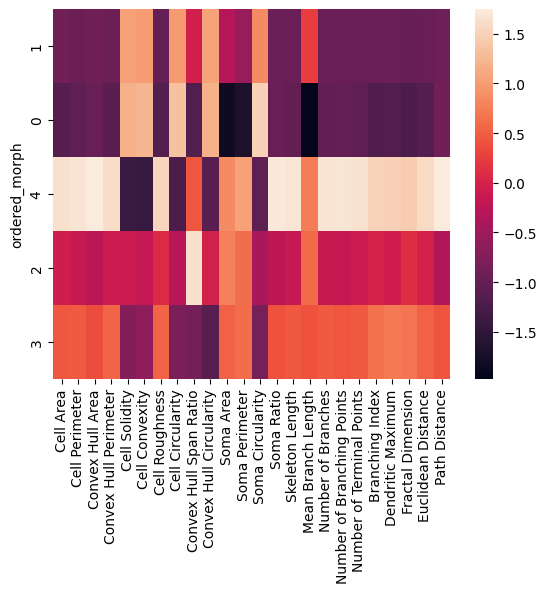

In [22]:
plot_clustered_heatmap_with_features(new_ad, features, group_col='ordered_morph',cmap='GnBu',output_pdf='figures/cluster_morph_by_features.pdf')

In [23]:
from adjustText import adjust_text
import gseapy as gp
def plot_morphology_correlation(corr_matrix, morphology_feature, top_n=10, output_pdf=None):
    """
    Plot the correlation of genes with a specific morphological feature, labeling the top N genes.
    Also return the list of the top N genes.
    
    Parameters:
    - corr_matrix: DataFrame containing Spearman correlation values (genes as rows, morphological features as columns).
    - morphology_feature: The specific morphology feature to plot correlations for.
    - top_n: The number of top genes to label (default is 10).
    
    Returns:
    - A plot showing correlations sorted in descending order, with the top N genes labeled and adjusted.
    - List of the top N genes by correlation.
    """
    # Ensure the morphology feature exists in the correlation matrix
    if morphology_feature not in corr_matrix.columns:
        raise ValueError(f"{morphology_feature} not found in corr_matrix columns.")
    
    # Sort the genes by their correlation with the selected morphological feature
    sorted_genes = corr_matrix[morphology_feature].sort_values(ascending=False)
    
    # Get the top N genes
    top_genes = sorted_genes.head(top_n).index.tolist()
    
    # Plot the correlation values
    plt.figure(figsize=(12, 5))
    plt.plot(sorted_genes.values, color='black', linewidth=2)
    
    # Collect the text objects for adjusting later
    texts = []
    
    # Label the top N genes
    for i in range(top_n):
        gene_name = sorted_genes.index[i]
        x_position = i
        y_position = sorted_genes.iloc[i]
        # Add the text objects to the list for adjustment
        texts.append(plt.text(x_position, y_position, gene_name, 
                              ha='center', va='bottom', fontsize=10, color='black'))
    
    # Adjust the labels to avoid overlap
    adjust_text(texts, only_move={'points':'y', 'text':'y'}, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))
    
    # Customize the plot
    plt.xlabel("Genes")
    plt.ylabel(r"$r_s$")
    plt.title(f"Correlation with {morphology_feature}")
    plt.xticks([])  # Remove x-ticks
    
    # Show the plot
    plt.tight_layout()
    if output_pdf:
        plt.savefig(f'{output_pdf}{morphology_feature}_correlation.pdf',format='pdf')
    plt.show()
    
    enrichr_results = gp.enrichr(
    gene_list=top_genes, 
    gene_sets='GO_Cellular_Component_2023',  # Database for cellular compartments
    organism='Mouse',  # Organism (can be 'Mouse', 'Human', etc.)
    )

    # Convert the results to a pandas DataFrame
    df_results = enrichr_results.results
    gp.barplot(enrichr_results.res2d, title='GO Enrichment', cutoff=0.05, figsize=(6,5),ofname=f'figures/{morphology_feature}_compartment.pdf')
    
    # Return the top N genes
    return top_genes

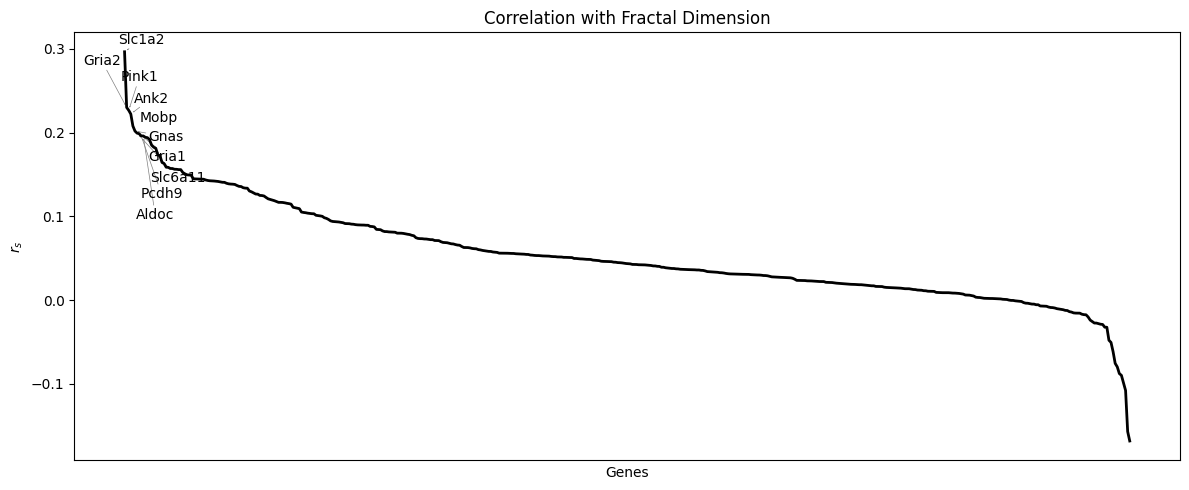

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


['Slc1a2',
 'Gria2',
 'Pink1',
 'Ank2',
 'Mobp',
 'Gnas',
 'Slc6a11',
 'Gria1',
 'Pcdh9',
 'Aldoc']

In [24]:
plot_morphology_correlation(corr_matrix, 'Fractal Dimension', top_n=10,output_pdf='figures/')

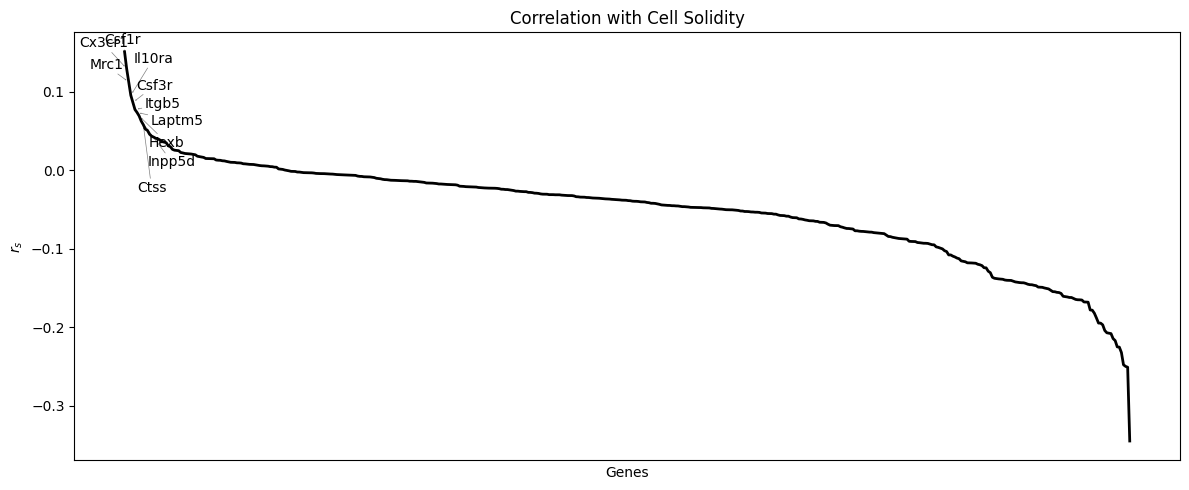

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


['Csf1r',
 'Cx3cr1',
 'Mrc1',
 'Il10ra',
 'Csf3r',
 'Itgb5',
 'Laptm5',
 'Hexb',
 'Inpp5d',
 'Ctss']

In [25]:
plot_morphology_correlation(corr_matrix, 'Cell Solidity', top_n=10,output_pdf='figures/')

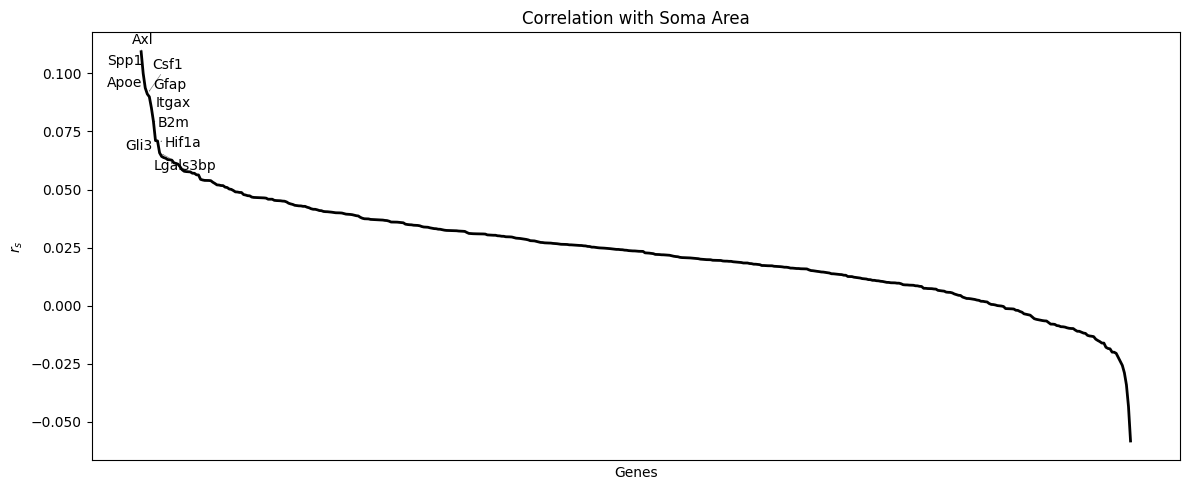

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


['Axl',
 'Spp1',
 'Apoe',
 'Csf1',
 'Gfap',
 'Itgax',
 'B2m',
 'Gli3',
 'Hif1a',
 'Lgals3bp']

In [26]:
plot_morphology_correlation(corr_matrix, 'Soma Area', top_n=10,output_pdf='figures/')

In [27]:
# region dependent effect
def calculate_region_spearman_corr(adata, gene_columns, morpho_columns, region_column):
    """
    Calculate Spearman correlation between gene expression and morphological features
    for each brain region separately.
    
    Parameters:
    - adata: AnnData object containing gene expression and morphological features.
    - gene_columns: List of gene names in adata.var_names.
    - morpho_columns: List of morphological feature names in adata.obs.
    - region_column: Column in adata.obs that contains the brain region information (e.g., 'Brain_Region').
    
    Returns:
    - A dictionary where each key is a brain region and the value is a DataFrame 
      with Spearman correlation coefficients between genes and morphological features.
    """
    # Extract morphological features from adata.obs
    morpho_df = adata.obs[morpho_columns]

    # Extract brain regions
    regions = adata.obs[region_column].unique()

    # Dictionary to store correlation matrices for each region
    region_corr_matrices = {}

    for region in regions:
        # Subset the data for the current region
        region_idx = adata.obs[region_column] == region
        region_adata = adata[region_idx]

        # Extract gene expression data for the region
        gene_expr_df = pd.DataFrame(region_adata[:, gene_columns].X.toarray(), columns=gene_columns, index=region_adata.obs_names)

        # Initialize a DataFrame to store the correlations for the current region
        corr_matrix = pd.DataFrame(index=gene_columns, columns=morpho_columns)

        # Calculate Spearman correlation for each gene-morphological feature pair
        for gene in gene_columns:
            for morpho in morpho_columns:
                # Ensure no shape mismatch by properly aligning the data
                gene_values = gene_expr_df[gene].values.flatten()  # Ensure it's 1D
                morpho_values = morpho_df.loc[region_adata.obs_names, morpho].values.flatten()  # Ensure it's 1D

                if len(gene_values) == len(morpho_values):
                    # Calculate Spearman correlation and only take the first value (correlation coefficient)
                    corr, _ = spearmanr(gene_values, morpho_values)
                    corr_matrix.at[gene, morpho] = corr
                else:
                    corr_matrix.at[gene, morpho] = None  # Handle any mismatch by assigning None or NaN

        # Store the correlation matrix for the region
        region_corr_matrices[region] = corr_matrix.astype(float)

    return region_corr_matrices
region_corrs = calculate_region_spearman_corr(new_ad, gene_columns=ordered, morpho_columns=ord_feat, region_column='Brain_Region')

/tmp/ipykernel_1436634/2437594183.py:46: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(gene_values, morpho_values)


In [28]:
def top_genes_per_region(region_corrs, regions, morphologies, top_n=5):
    """
    For each region, find the top N genes with the highest average correlation across selected morphology features.
    
    Parameters:
    - region_corrs: Dictionary where each key is a brain region and value is a correlation matrix.
    - regions: List of regions to include in the ranking.
    - morphologies: List of morphological feature names to include in the ranking.
    - top_n: Number of top genes to return (default is 5).
    
    Returns:
    - A dictionary where each key is a region, and the value is a DataFrame containing the top N genes
      with the highest average correlation across the selected morphology features.
    """
    # Dictionary to store top genes for each region
    top_genes_dict = {}

    # Iterate over the regions and find top N genes
    for region in regions:
        if region in region_corrs:
            # Extract the correlation matrix for the current region
            corr_matrix = region_corrs[region].loc[:, morphologies]
            
            # Calculate the average correlation for each gene across the selected morphologies
            avg_corrs = corr_matrix.mean(axis=1)
            
            # Sort the genes by average correlation in descending order and select the top N
            top_genes = avg_corrs.sort_values(ascending=False).head(top_n)
            
            # Store the result in the dictionary
            top_genes_dict[region] = top_genes.reset_index().rename(columns={0: 'Avg_Correlation'})
        else:
            raise ValueError(f"Region '{region}' not found in correlation dictionary.")

    return top_genes_dict

def plot_gene_region_count(top_genes_by_region,output_pdf=None):
    """
    Plot a barplot showing how many regions each gene appears in based on the top genes per region.
    The barplot will be sorted by the number of regions in descending order.
    
    Parameters:
    - top_genes_by_region: Dictionary where each key is a region, and the value is a DataFrame containing
      the top genes with the highest average correlation in that region.
    
    Returns:
    - A sorted bar plot showing the number of regions each gene appears in.
    """
    # Create a list to store the genes across all regions
    all_genes = []

    # Collect all genes from the top_genes_by_region dictionary
    for region, df in top_genes_by_region.items():
        all_genes.extend(df['index'])  # Changed 'Gene' to 'index' based on your DataFrame

    # Create a DataFrame to count the occurrence of each gene across regions
    gene_counts = pd.Series(all_genes).value_counts().reset_index()
    gene_counts.columns = ['Gene', 'Region_Count']

    # Sort the DataFrame by the number of regions in descending order
    gene_counts = gene_counts.sort_values(by='Region_Count', ascending=False)

    # Plot the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(gene_counts['Gene'], gene_counts['Region_Count'], color='skyblue')
    plt.xlabel('Genes')
    plt.ylabel('Number of Regions')
    plt.title('Number of Regions Each Gene Appears In (Top Genes)')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    if output_pdf:
        plt.savefig(output_pdf,format='pdf')

    # Show the plot
    plt.show()

In [34]:
regions = ['MPM', 'Cerebellum', 'Cortex', 'Hippocampus', 'Hypothalamus', 'Thalamus', 'Basal_Ganglia']

In [36]:
cluster_1_feat = ["Cell Area", "Convex Hull Perimeter", "Convex Hull Area", "Cell Perimeter", 
    "Number of Branches", "Skeleton Length", "Number of Branching Points", 
    "Number of Terminal Points", "Cell Roughness", "Path Distance", 
    "Fractal Dimension", "Euclidean Distance", "Soma Ratio", 
    "Branching Index", "Dendritic Maximum"]

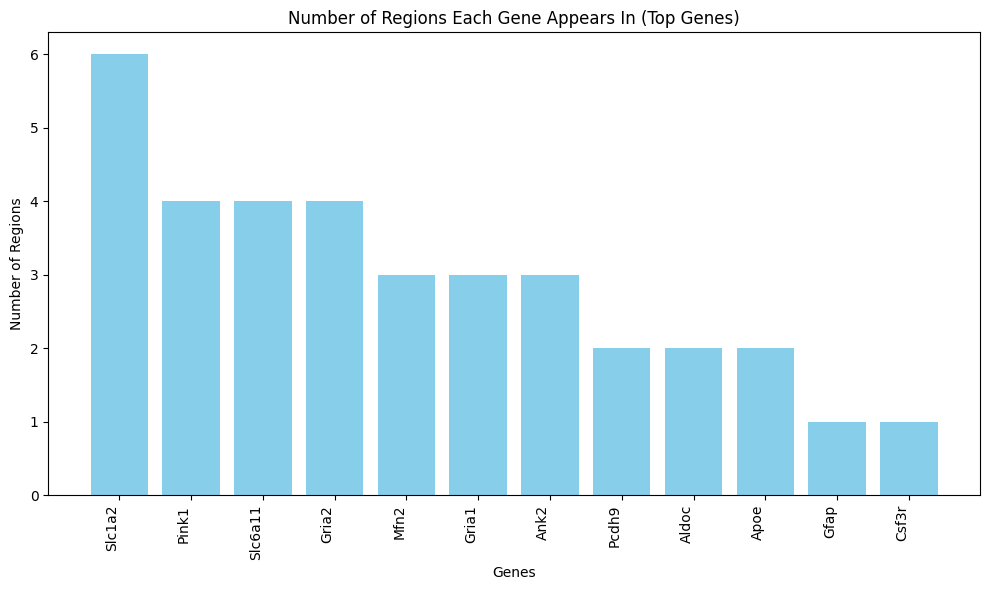

In [37]:
top_genes_by_region = top_genes_per_region(
    region_corrs=region_corrs,
    regions=regions,
    morphologies=cluster_1_feat,
    top_n=5
)

plot_gene_region_count(top_genes_by_region,'figures/region_count_branch_structures.pdf')

In [38]:
genes_branch = ['Slc1a2','Pink1','Slc6a11','Gria2','Mfn2','Gria1','Ank2','Pcdh9','Aldoc','Apoe','Gfap','Csf3r']

In [39]:
enrichr_results = gp.enrichr(
    gene_list=genes_branch, 
    gene_sets='GO_Cellular_Component_2023',  # Database for cellular compartments
    organism='Mouse',  # Organism (can be 'Mouse', 'Human', etc.)
    )

    # Convert the results to a pandas DataFrame
df_results = enrichr_results.results
gp.barplot(enrichr_results.res2d, title='GO Enrichment', cutoff=0.05, figsize=(6,5),ofname=f'figures/branches_compartment.pdf')

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(
